# Import Modules

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import os
import shutil
import PIL
import cv2
import random
from datetime import datetime

## Set Up Constants

In [49]:
RANDOM_SEED = 69
random.seed(RANDOM_SEED)

## Dir Check and Data Setup
Make sure Directories are working and `plt` is working 

Grabs a random sample from each dataset

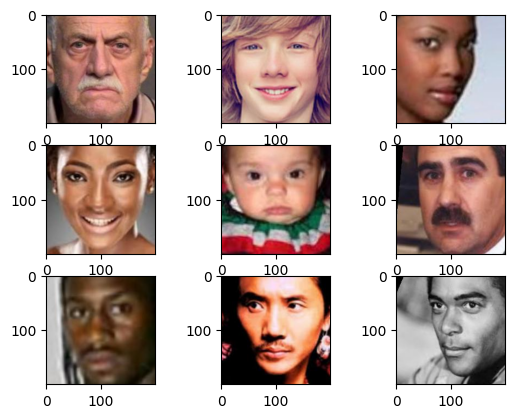

In [50]:
# define location of datasets
utk_face = 'datasets/UTKFace/'
# plot 9 random images
utk_list = []


for (dirp, dirn, filen) in os.walk(utk_face):
    utk_list.extend(random.sample(filen,9))
    break

break_iter = 0
for iter,file in enumerate(utk_list):
    plt.subplot(330 + 1 + (iter % 9))
    # define filename
    # load image pixels
    image = plt.imread(utk_face+file)
    # plot raw pixel data
    plt.imshow(image)
    if break_iter >= 9:
        break
# show the figure
plt.show()

It works, now lets combine the data sets

# Clear Directories and Set up Database
This is usually cancelled with %%script false, but done if the data needs to be reset

In [51]:
#%%script false

# clear the directory if it exists, it it doesn't create it
dataset_home = 'data' + os.sep
subdirs = ['train' + os.sep , 'test' + os.sep]

for subdir in subdirs:
    directory_path = os.path.join(dataset_home,subdir)
    if os.path.exists(directory_path):
        # Remove all files in the directory
        for filename in os.listdir(directory_path):
            file_path = os.path.join(directory_path, filename)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f"Error cleaning {file_path}: {e}")
    else:
        print(f"The directory {directory_path} does not exist.")
        
# Make Directories for Age
for subdir in subdirs:
    for i in range (0,117): #max range of both the data sets
        os.makedirs(os.path.join(dataset_home,subdir,str(i)), exist_ok = True)

# Bring in both data sets and split them, 
# utk_face filename starts with one, fg_net starts with 2 
# This has been done for potential debugging
test_ratio = 0.1 

for iter,file in enumerate(os.listdir(utk_face)):
    src = utk_face  + file
    
    # break down the file name to get age data
    string_lab = file.split("_")
    age = string_lab[0]
    
    dst_dir = os.path.join(dataset_home, subdirs[0])
    if random.random() < test_ratio:
        dst_dir = os.path.join(dataset_home,subdirs[1])
           
    photo = tf.keras.utils.load_img(src, target_size=(200, 200))
    photo.save(os.path.join(dst_dir,str(age),"1_"+ str(age) +"_i_" + str(iter)+".jpg"))
        

- training ration is 0.9
- validation 0.2


# CNN Stuff

Bellow defines the size and propigation settings for the CNN

In [52]:
EPOCHS_CONST = 100
ERRORS_TIL_STOP = 10

IMG_SIZE=64     #Img size
ROWS = 256      #Img size
COLS = 256      #Img size
CHANNELS = 3    #RGB
batch_size=64   #What was shown as a good number for back propogation in AlexNet

data_dir='data/train/'
test_dir='data/test/'

In [53]:
print(data_dir)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.9, 
  subset="training",    #20%-80% of data for training
  seed=RANDOM_SEED,
  image_size=(ROWS, COLS),
  batch_size=batch_size)



data/train/
Found 21321 files belonging to 117 classes.
Using 2133 files for training.


In [54]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,     #20% of data for valifation
  subset="validation",
  seed=RANDOM_SEED,
  image_size=(ROWS, COLS),
  batch_size=batch_size)




Found 21321 files belonging to 117 classes.
Using 4264 files for validation.


## Check Data Loader

117


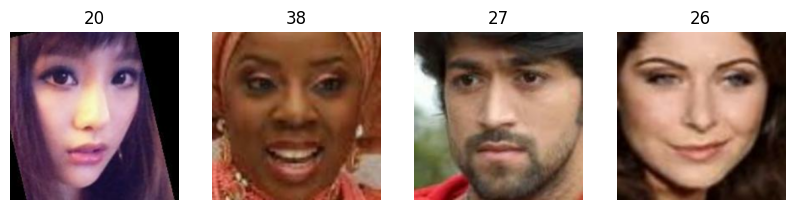

In [55]:
# Need the directories for the number
data_dir_names = list(os.listdir(data_dir))
print(len(data_dir_names))

# Needed for propper labeling
class_names = train_ds.class_names

# Check if it works
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(1,4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])  # Has weird internal organising, class names needed
        plt.axis("off")


    

In [56]:
#Check the labeling
print("Train shape: {}".format(images[1].shape))
print(class_names)

Train shape: (256, 256, 3)
['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


## Set up the training model

In [57]:
num_classes = len(data_dir_names)
data_augmentation = False #True

In [58]:
# preprocessing and real time data augmentation
# Using Alex.net
data_augmentation = keras.Sequential(
    [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(ROWS, COLS, 3))
    ]
)
model = keras.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(96, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='linear')
])

In [59]:
# Model Compile and Summary
model.compile(optimizer='adam',
              loss='mean_squared_error',  # Use mean squared error for regression
              metrics=['mean_absolute_error']) 

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 30, 30, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 30, 30, 256)       614656    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 256)       0         
 ng2D)                                                

# Training

In [60]:
# callback function to monitor the loss and stop training if loss does not decrease for 5 consecutive epochs
callback =tf.keras.callbacks.EarlyStopping(
    mode = "min",
    monitor= "val_mean_absolute_error",#'val_loss',
    min_delta=0.0000000000001, #0.0000001,
    patience=ERRORS_TIL_STOP)

history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=EPOCHS_CONST,
    callbacks=[callback]
)

# And Save
model.save('savedmodel') # savedmodel

Epoch 1/100


34/34 [==============================] - 121s 4s/step - loss: 2809.8835 - mean_absolute_error: 43.7615 - val_loss: 717.4376 - val_mean_absolute_error: 19.6174
Epoch 2/100
34/34 [==============================] - 125s 4s/step - loss: 576.9417 - mean_absolute_error: 18.3807 - val_loss: 497.5703 - val_mean_absolute_error: 17.7595
Epoch 3/100
34/34 [==============================] - 129s 4s/step - loss: 499.5860 - mean_absolute_error: 17.4739 - val_loss: 497.7169 - val_mean_absolute_error: 16.5077
Epoch 4/100
34/34 [==============================] - 122s 4s/step - loss: 497.0540 - mean_absolute_error: 17.2103 - val_loss: 492.1445 - val_mean_absolute_error: 16.5664
Epoch 5/100
34/34 [==============================] - 129s 4s/step - loss: 506.6637 - mean_absolute_error: 17.4910 - val_loss: 486.7047 - val_mean_absolute_error: 16.7557
Epoch 6/100
34/34 [==============================] - 127s 4s/step - loss: 507.2729 - mean_absolute_error: 17.5233 - val_loss: 538.5917 - val_mean_absolute_error:

INFO:tensorflow:Assets written to: savedmodel\assets


## Training Graphs
Data means next to nothing if it can't be compared and seen

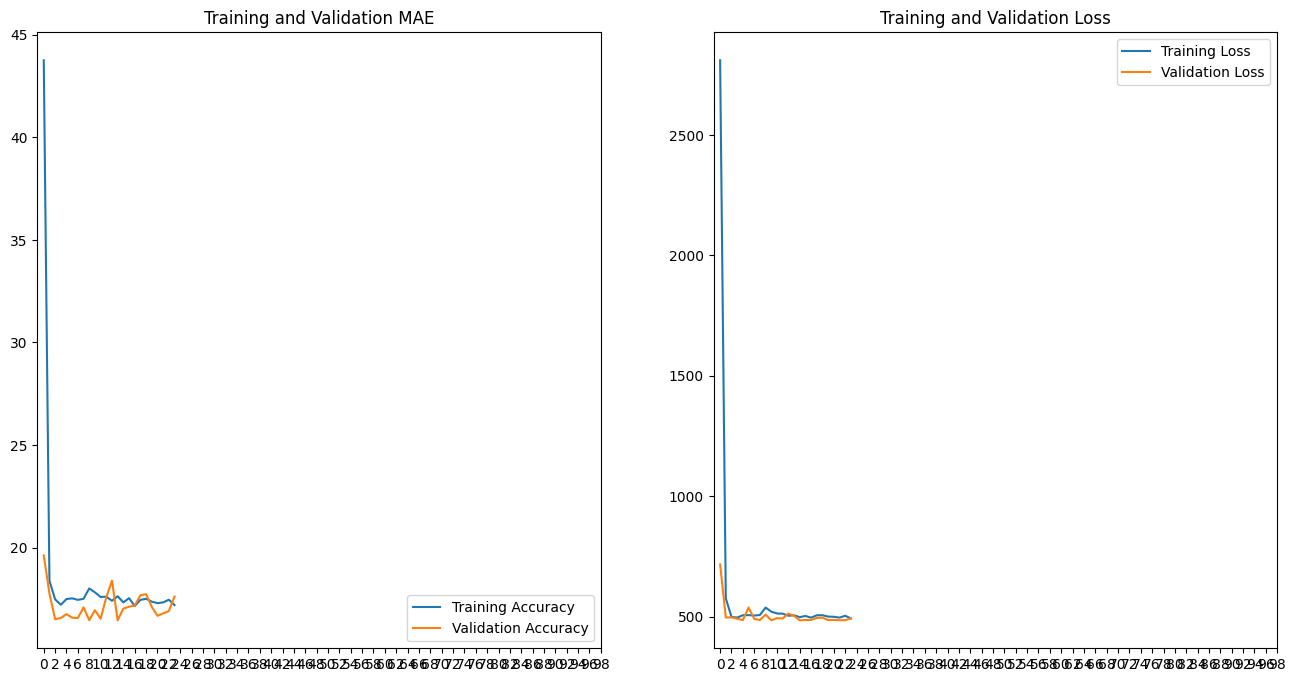

In [61]:
# Training History Graphs

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

mse = history.history['loss']  
val_mse = history.history['val_loss']



epochs_range = range(EPOCHS_CONST)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(mae, label='Training Accuracy')
plt.plot( val_mae, label='Validation Accuracy')
plt.xticks(range(0,EPOCHS_CONST)[0::2])
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(mse, label='Training Loss')
plt.plot(val_mse, label='Validation Loss')
plt.xticks(range(0,EPOCHS_CONST)[0::2])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Testing

## Configure Test Data

In [62]:
print(data_dir)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  validation_split=0.0, 
  seed=RANDOM_SEED,
  image_size=(ROWS, COLS),
  batch_size=batch_size)



data/train/
Found 2387 files belonging to 117 classes.


## Test with the Test Data

In [63]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Mean Absolute Error (Lower Better): {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.4f}")

38/38 [==============================] - 19s 501ms/step - loss: 517.2498 - mean_absolute_error: 17.9964
Mean Absolute Error (Lower Better): 18.00
Test Loss: 517.2498


# Graph Results

1/1 [==============================] - 0s 120ms/step
50.04979 at 1
1/1 [==============================] - 0s 56ms/step
50.013954 at 1
1/1 [==============================] - 0s 42ms/step
51.35932 at 1
1/1 [==============================] - 0s 42ms/step
50.013954 at 1
1/1 [==============================] - 0s 42ms/step
50.08304 at 1
1/1 [==============================] - 0s 42ms/step
50.014393 at 1
1/1 [==============================] - 0s 45ms/step
50.013954 at 1
1/1 [==============================] - 0s 44ms/step
50.05205 at 10
1/1 [==============================] - 0s 42ms/step
50.013954 at 10
1/1 [==============================] - 0s 42ms/step
50.097275 at 10
1/1 [==============================] - 0s 41ms/step
50.074646 at 10
1/1 [==============================] - 0s 44ms/step
50.018124 at 10
1/1 [==============================] - 0s 42ms/step
50.02354 at 10
1/1 [==============================] - 0s 41ms/step
50.269505 at 10
1/1 [==============================] - 0s 41ms/step
50.0139

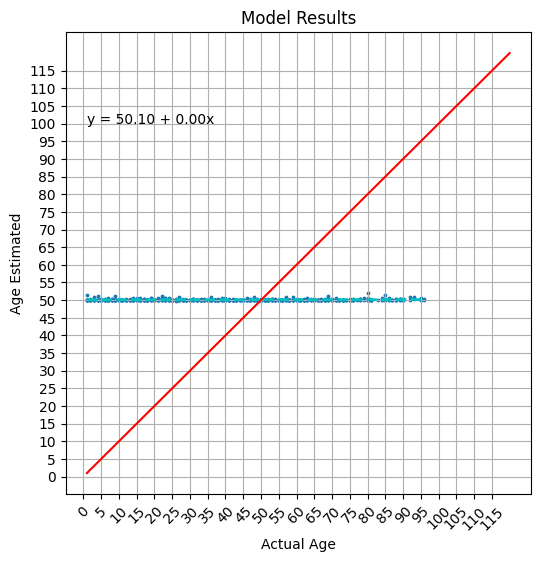

In [64]:
# Make a Plot to show difference

import random
import matplotlib.pyplot as plt

test_data = "data/test"
num_each = 5

x = []
y = []

for dir in os.listdir(test_data):
    files = os.path.join(test_data,dir)
    
    for intg,file in enumerate(os.listdir(files)):   
        ful_name = os.path.join(files,file)
        img = keras.preprocessing.image.load_img(
            ful_name, target_size=(ROWS, COLS))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        
        y.append(float(str(predictions)[2:-2]))
        x.append(int(dir))
        
        print(f"{float(str(predictions)[2:-2])} at {int(dir)}")
        
        if intg > num_each:
            break

npx = np.array(x)
npy = np.array(y)
        
#find line of best fit
a, b = np.polyfit(npx, npy, 1)

plt.figure(figsize=(6, 6))
ax = plt.axes()
ax.scatter(x,y,s=3)
ax.plot([1, 2, 4, 50,100,120], [1, 2, 4, 50,100,120], c = "r")

ax.set_xlabel('Actual Age')
ax.set_ylabel('Age Estimated')
plt.xticks([i for i in range(0,120,5)] )
plt.yticks([i for i in range(0,120,5)] )
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
plt.grid()
plt.plot(npx, a*npx+b, color='c', linestyle='--', linewidth=2)
plt.text(1, 100, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)

plt.title("Model Results")

plt.show()